# Example of 1D Regression OOD detection using a Gaussian Processes

1. For the **offline/batched case**: we have training data $\{(x_i, y_i)\}^n_{i=1}$ offline. Then we have a batch of test data $\{x^*_i\}^m_{i=1}$ for which we have to predict $h(x^*_i)$, i.e., whether $x^*_i$ is OOD.
2. For the **online case**: we have training data $\{(x_i, y_i)\}^n_{i=1}$ offline. Then data stream online as (either temporally depedent or not) as $(x_{t+1}, y_{t+1})$, and we want to detect whether each single incoming $(x_{t+1}, y_{t+1})$ is OOD via $p(x_{t+1}, y_{t+1}) = p(y_{t+1} | x_{t+1}) p(x_{t+1})$.
    - For this case we can use the online updated GP in this [paper](https://arxiv.org/pdf/2103.01454.pdf), and of this [github](https://github.com/wjmaddox/online_gp/tree/main), to also update the posterior

Also, look at this [post](https://stats.stackexchange.com/questions/520796/using-gaussian-processes-to-learn-a-function-online) to see how we update the GP posterior predictive online.

In [1]:
import torch
import numpy as np
from models.gps import ExactGP, SVGP, setup_model, train_model

from utils.utils import single_x_f, single_x_f_OOD
from utils.utils import plot_gp_fit, plot_ID_OOD
from utils.utils import compute_metrics

In [2]:
# Options
N = 1000
P = 1

# Generate data
X_train = torch.linspace(-3, 3, N).unsqueeze(-1)
X_train = torch.cat([X_train for _ in range(P)], dim=1)
y_train = single_x_f(X_train).reshape(-1)

# Set the seeds
torch.manual_seed(43)

## 1) Train and Plot the model

In [3]:
# 1) Train the model
input_dim = X_train.size(-1)
gp_mod = ExactGP(train_x=X_train, train_y=y_train)
# gp_mod = SVGP(input_dim, 500)
likel, obj_fun, optim = setup_model(gp_mod, y_train, learning_rate=0.1)
gp_model = {'model': gp_mod, 'likelihood': likel, 'objective_function': obj_fun, 'optimizer': optim}

train_model(gp_model, X_train, y_train, training_iterations=50, verbose=False)

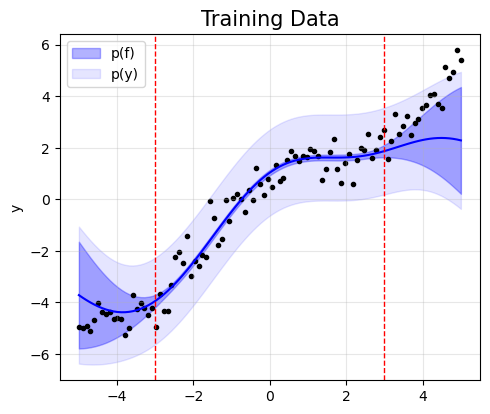

In [4]:
# Plot the model
X_test = torch.linspace(-5, 5, 100).unsqueeze(-1)
y_test = single_x_f(X_test).reshape(-1)
plot_gp_fit(gp_model['model'], gp_model['likelihood'], X_test, y_test, title='Training Data')

## 2) Train OOD detection model
This is done by training the acceptable threshold on the training data. The idea of a distribution distance based OOD detection with a GP model is as follows. We have a trained GP model on some train data. Given a test point $x^*$ we can get its “current” predictive posterior $p_{\theta} (y | x^*)$ and the closed-form updated $p_{\theta'} (y | x^*)$. Then, for each $x^*$, we can compute any distance based divergence: i) IG (as KL divergence b/w the two above $p(\cdot | \cdot)$; ii) Kolmogorov-Sminrnov via the cdf; iii) Wasserstein distance via the cdf; iv) MMD via the cdf; v) etc. Then, we can use the distribution distance as a feature for OOD detection.

### 2.1) Closed-form update of the GP posterior

Closed form update of the GP posterior ([post](https://stats.stackexchange.com/questions/520796/using-gaussian-processes-to-learn-a-function-online)) is done in the following way. After training the model, with prior $f \sim \mathcal{GP} (m_0(x), K_0(x,x))$, on the $\{(x_i, y_i)\}^n_{i=1}$ data, we have that the predictive posterior at a new point $x^*$ for $f^* = f(x^*)$ is given by the following:
$$\left(\begin{array}{c}\mathbf{f}_n \\ f_*\end{array}\right) \sim \mathcal{N}\left( \left[\begin{array}{c}\mathbf{m}_n (x) \\ m(x^*)\end{array} \right] ,\left[\begin{array}{c|c}K_n+ \sigma^2 I_n & k_* \\ \hline k_*^T & k_{* *}\end{array}\right]\right)$$
where $\mathbf{f}_n = [ f(x_1), \ldots, f(x_n) ]$, $ m_n (x) = [ m(x_1), \ldots, m(x_n) ]$, $K_n = [K(x_1, x_1), \ldots, K(x_n, x_n) ]$, $k_* = [ K(x_1, x^*), \ldots, K(x_n, x^*) ]$, $k_{* *} = K(x^*, x^*)$, and $\sigma^2$ is the noise variance. When we observe a new $x^*$ at test time, and we want to predict $f^* = f(x^*)$, we do so by computing $f^* | f(x_{1:n}) \sim \mathcal{N} (m_n(x), \sigma^2_n (x))$ where:
$$
m_n (x^*) = m_0(x^*) + K (x_{1:n}, x^*)^T \big( K (x_{1:n}, x_{1:n}) + \sigma^2 I_n \big)^{-1} (y_{1:n} - m_0 (x^*)) \\
\sigma_n^2 (x^*) = K (x^*, x^*) - K (x^*, x_{1:n})^T \big( K (x_{1:n}, x_{1:n}) + \sigma^2 I_n \big)^{-1} K (x_{1:n}, x^*)
$$
While after we observe the entire pair $(x^*, y^*)$, the updated predictive posterior is given by:
$$
m_{n+1} (x^*) = m_0 (x^*) + K (x_{1:n}, x^*)^T \big( K (x_{1:(n+1)}, x_{1:(n+1)}) + \sigma^2 I_{1:(n+1)} \big)^{-1} (y_{1:(n+1)} - m_{1:(n+1)} (x^*)) \\
\sigma_{n+1}^2 (x^*) = K (x^*, x^*) - K (x_{1:n}, x^*)^T \big( K (x_{1:(n+1)}, x_{1:(n+1)}) + \sigma^2 I_{1:(n+1)} \big)^{-1} K (x_{1:n}, x^*)
$$
 

#### Semantic OOD shift point p(y^* | x)

In [5]:
from utils.OOD_tests import print_dist, print_dist_OOD

# Given a test point x, suppose out of sample, get its updated posterior
x_test = torch.tensor([1.0]).unsqueeze(-1)
y_test = single_x_f(x_test, noise=False).reshape(-1)
y_test_OOD = single_x_f_OOD(x_test, noise=False).reshape(-1)

prior_mean = gp_model['model'](x_test).mean
# prior_covar = torch.max(gp_model['model'](X_train).variance)
prior_covar = torch.quantile(gp_model['model'](X_train).variance, 0.95)

updated_mean, updated_covar = gp_model['model'].update_posterior_xi(X_train, x_test, y_train, y_test, gp_model['likelihood'])
updated_mean_OOD, updated_covar_OOD = gp_model['model'].update_posterior_xi(X_train, x_test, y_train, y_test_OOD, gp_model['likelihood'])

print("********** ID point p(y^* | x) **********\n")
print_dist(x_test, y_test, prior_mean, prior_covar, updated_mean, updated_covar)

********** ID point p(y^* | x) **********

Prior mean: 1.594 Updated mean: 1.539 True value: 1.54
Prior variance: 0.009 Updated variance: 0.003
KL divergence: 21.171
JS divergence: 11.927
Wasserstein distance: 0.055
KS statistic: 0.351
Mahalanobis distance: 0.575


/Users/acaron/anaconda3/envs/OOD_RL/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [6]:
print("********** OOD point p(y^* | x) **********\n")
print_dist_OOD(x_test, y_test_OOD, prior_mean, prior_covar, updated_mean_OOD, updated_covar_OOD)

********** OOD point p(y^* | x) **********

Prior mean: 1.594 Updated mean: 3.037 True value: 3.04
Prior variance: 0.009 Updated variance: 0.003
KL divergence: 14020.81
JS divergence: 7967.509
Wasserstein distance: 1.443
KS statistic: 1.0
Mahalanobis distance: 15.581


#### Covariate OOD shift point p(x)

In [7]:
# ID point x
x_test = torch.tensor([1.0]).unsqueeze(-1)
y_test = single_x_f(x_test, noise=False).reshape(-1)

prior_mean = gp_model['model'](x_test).mean
# prior_covar = torch.max(gp_model['model'](X_train).variance)
prior_covar = torch.quantile(gp_model['model'](X_train).variance, 0.95)

updated_mean, updated_covar = gp_model['model'].update_posterior_xi(X_train, x_test, y_train, y_test, gp_model['likelihood'])

print("\n********** ID point x^* **********\n")
print_dist(x_test, y_test, prior_mean, prior_covar, updated_mean, updated_covar)


********** ID point x^* **********

Prior mean: 1.594 Updated mean: 1.539 True value: 1.54
Prior variance: 0.009 Updated variance: 0.003
KL divergence: 21.171
JS divergence: 11.927
Wasserstein distance: 0.055
KS statistic: 0.351
Mahalanobis distance: 0.575


In [8]:
# OOD point x^*
x_test = torch.tensor([-10.0]).unsqueeze(-1)
y_test = single_x_f(x_test, noise=False).reshape(-1)

# prior = gp_model['model'](x_test)
# prior_mean, prior_covar = prior.mean, prior.covariance_matrix

prior_mean = gp_model['model'](x_test).mean
# prior_covar = torch.max(gp_model['model'](X_train).variance)
prior_covar = torch.quantile(gp_model['model'](X_train).variance, 0.95)

updated_mean, updated_covar = gp_model['model'].update_posterior_xi(X_train, x_test, y_train, y_test, gp_model['likelihood'])

print("********** OOD point x^* **********\n")
print_dist(x_test, y_test, prior_mean, prior_covar, updated_mean, updated_covar)

********** OOD point x^* **********

Prior mean: -0.405 Updated mean: -0.428 True value: -10.839
Prior variance: 0.009 Updated variance: 3.263
KL divergence: 71628.82
JS divergence: 2.772
Wasserstein distance: 3.254
KS statistic: 0.448
Mahalanobis distance: 112.38


Notice how the updated mean is closer to the true value of the function at $x^*$ than the prior mean. This is because the updated mean is a weighted average of the prior mean and the observed data. The updated variance is also smaller than the prior variance, which is expected since we have observed new $n+1$ data at $x^*$.

Notice also that using a noiseless GP should imply that the updated mean coincide with the new observed data point in the case of OOD x^*, **but here it does not because we trained with noise above, and this is reflected in the calculations of covariance when updating the posterior**.

### 2.2) Train the OOD detection model

We train the OOD detector over K-folds, 80%-20% train-validation set split. We do this by training the GP model on train set, and compute the acceptable thresholds (i.e., the test critical value) $\tau_{1-\alpha} (x_{train})$ on the validation data, where $\tau_{1-\alpha} (x_{train})$ is the $(1-\alpha)$ quantile of the test statistics on the training data. We do this for values $\alpha = \{0.10, 0.05, 0.01\}$.

In [9]:
from utils.OOD_tests import OOD_detector

# Initialize and train the OOD detector
OOD_model = OOD_detector(input_dim, model='ExactGP', lr=0.1, num_ind_pts=200)
OOD_model.train_OOD(X_train, y_train, training_iterations=50, verbose=False, K=2)

Training fold 1/2...
Training fold 2/2...


## 3) Test the OOD detector on a batch of test data

### 3.1) Far OOD shift in $p(y|x)$

By Far OOD we mean a case where the $p_{ood}$ is far apart enough from the $p_{id}$, to make the detection easier. In our case this depicts a shift in the mean of the function.

We now generate unseen test data, and test the OOD detector on it. We generate a batch of test data, of size 100, of which some are ID and some are OOD. We generate $X$ uniformly at random in $[-5, 5]$. We then test the OOD detector on this batch of test data.

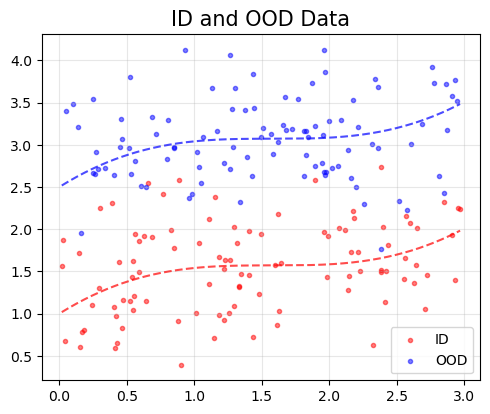

In [10]:
# 2) Test Time: we have a batch of test, of size 100, of which some are ID and some are OOD
# Generate X uniformly at random in [-5, 5]
X_test_ID = torch.rand(100, 1) * 3 - 0
X_test_OOD = torch.rand(100, 1) * 3 + 0

y_test_ID = single_x_f(X_test_ID).reshape(-1)
# y_test_OOD = single_x_f(X_test_OOD).reshape(-1)
y_test_OOD = single_x_f_OOD(X_test_OOD, OOD_type='Far').reshape(-1)

plot_ID_OOD(X_test_ID, X_test_OOD, y_test_ID, y_test_OOD)

In [11]:
# Stack ID and OOD test data altogether
X_test = torch.cat([X_test_ID, X_test_OOD], dim=0)
y_test = torch.cat([y_test_ID, y_test_OOD], dim=0)

# Create associated true OOD labels
OOD_labels = torch.cat([torch.zeros(y_test_ID.size(0)), torch.ones(y_test_OOD.size(0))], dim=0)

# Test the OOD detector
OOD_pred_95 = dict()
OOD_pred_95['pred_error'], OOD_pred_95['kl_div'], OOD_pred_95['js_div'], OOD_pred_95['ks_stat'], OOD_pred_95['wass_dist'], OOD_pred_95['maha_dist'] = OOD_model.predict_OOD(X_test, y_test, alpha=0.05)
# print(OOD_pred_95)

In [12]:
compute_metrics(OOD_pred_95, OOD_labels)


******** Method: pred_error ********
AUROC: 0.9049999999999999
TPR: 0.86
FPR: 0.05
F1 score: 0.9005235602094239

******** Method: kl_div ********
AUROC: 0.9049999999999999
TPR: 0.86
FPR: 0.05
F1 score: 0.9005235602094239

******** Method: js_div ********
AUROC: 0.9
TPR: 0.88
FPR: 0.08
F1 score: 0.8979591836734694

******** Method: ks_stat ********
AUROC: 0.5
TPR: 0.0
FPR: 0.0
F1 score: 0.0

******** Method: wass_dist ********
AUROC: 0.9
TPR: 0.85
FPR: 0.05
F1 score: 0.8947368421052632

******** Method: maha_dist ********
AUROC: 0.89
TPR: 0.85
FPR: 0.07
F1 score: 0.8854166666666666


### 3.2) Near OOD shift in $p(y|x)$

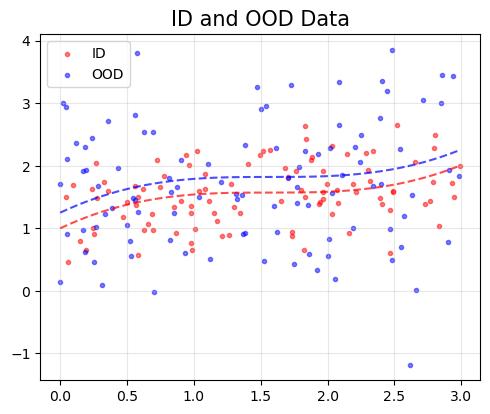

In [13]:
# 2) Test Time: we have a batch of test, of size 100, of which some are ID and some are OOD
# Generate X uniformly at random in [-5, 5]
X_test_ID = torch.rand(100, 1) * 3 - 0
X_test_OOD = torch.rand(100, 1) * 3 + 0

y_test_ID = single_x_f(X_test_ID).reshape(-1)
# y_test_OOD = single_x_f(X_test_OOD).reshape(-1)
y_test_OOD = single_x_f_OOD(X_test_OOD, OOD_type='Near').reshape(-1)

plot_ID_OOD(X_test_ID, X_test_OOD, y_test_ID, y_test_OOD, OOD_type='Near')

In [14]:
# Stack ID and OOD test data altogether
X_test = torch.cat([X_test_ID, X_test_OOD], dim=0)
y_test = torch.cat([y_test_ID, y_test_OOD], dim=0)

# Create associated true OOD labels
OOD_labels = torch.cat([torch.zeros(y_test_ID.size(0)), torch.ones(y_test_OOD.size(0))], dim=0)

# Test the OOD detector
OOD_pred_95 = dict()
OOD_pred_95['pred_error'], OOD_pred_95['kl_div'], OOD_pred_95['js_div'], OOD_pred_95['ks_stat'], OOD_pred_95['wass_dist'], OOD_pred_95['maha_dist'] = OOD_model.predict_OOD(X_test, y_test, alpha=0.05)
# print(OOD_pred_95)

/Users/acaron/anaconda3/envs/OOD_RL/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [15]:
compute_metrics(OOD_pred_95, OOD_labels)


******** Method: pred_error ********
AUROC: 0.63
TPR: 0.26
FPR: 0.0
F1 score: 0.41269841269841273

******** Method: kl_div ********
AUROC: 0.63
TPR: 0.26
FPR: 0.0
F1 score: 0.41269841269841273

******** Method: js_div ********
AUROC: 0.605
TPR: 0.21
FPR: 0.0
F1 score: 0.34710743801652894

******** Method: ks_stat ********
AUROC: 0.5
TPR: 0.0
FPR: 0.0
F1 score: 0.0

******** Method: wass_dist ********
AUROC: 0.63
TPR: 0.26
FPR: 0.0
F1 score: 0.41269841269841273

******** Method: maha_dist ********
AUROC: 0.605
TPR: 0.21
FPR: 0.0
F1 score: 0.34710743801652894


### 3.3) Shift in $p(x)$

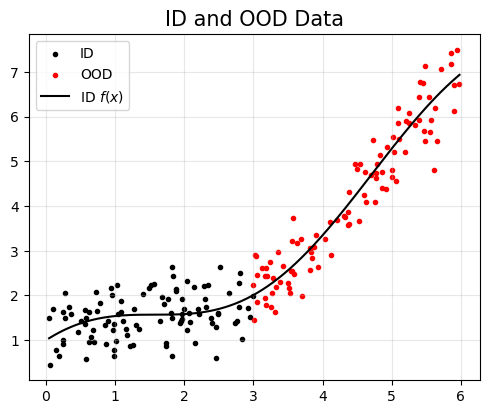

In [13]:
# 2) Test Time: we have a batch of test, of size 100, of which some are ID and some are OOD
# Generate X uniformly at random in [-5, 5]
X_test_ID = torch.rand(100, 1) * 3 - 0
X_test_OOD = torch.rand(100, 1) * 3 + 3

y_test_ID = single_x_f(X_test_ID).reshape(-1)
y_test_OOD = single_x_f(X_test_OOD).reshape(-1)

plot_ID_OOD(X_test_ID, X_test_OOD, y_test_ID, y_test_OOD, type='OOD')

In [14]:
# Stack ID and OOD test data altogether
X_test = torch.cat([X_test_ID, X_test_OOD], dim=0)
y_test = torch.cat([y_test_ID, y_test_OOD], dim=0)

# Create associated true OOD labels
OOD_labels = torch.cat([torch.zeros(y_test_ID.size(0)), torch.ones(y_test_OOD.size(0))], dim=0)

# Test the OOD detector
OOD_pred_95 = dict()
OOD_pred_95['pred_error'], OOD_pred_95['kl_div'], OOD_pred_95['js_div'], OOD_pred_95['ks_stat'], OOD_pred_95['wass_dist'], OOD_pred_95['maha_dist'] = OOD_model.predict_OOD(X_test, y_test, alpha=0.05)
# print(OOD_pred_95)

/Users/acaron/anaconda3/envs/OOD_RL/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [15]:
compute_metrics(OOD_pred_95, OOD_labels)


******** Method: pred_error ********
AUROC: 0.8250000000000001
TPR: 0.66
FPR: 0.01
F1 score: 0.7904191616766467

******** Method: kl_div ********
AUROC: 0.7799999999999999
TPR: 0.57
FPR: 0.01
F1 score: 0.721518987341772

******** Method: js_div ********
AUROC: 0.5
TPR: 0.0
FPR: 0.0
F1 score: 0.0

******** Method: ks_stat ********
AUROC: 0.5
TPR: 0.0
FPR: 0.0
F1 score: 0.0

******** Method: wass_dist ********
AUROC: 0.7799999999999999
TPR: 0.57
FPR: 0.01
F1 score: 0.721518987341772

******** Method: maha_dist ********
AUROC: 0.5
TPR: 0.0
FPR: 0.0
F1 score: 0.0
